<h1 style="text-align: center">
<strong>WEB SCRAPING - REPOSITORIO DE UNSA</strong>
</h1>

**Nombre:** Oliverio Pichardo Diestra

**Descripción del caso:**
Se quiere obtener información estructurada de las tesis de pregrado y posgrado de Estadística, Informática o de carreras similares desarrolladas a nivel  nacional, a través de los repositorios institucionales de las universidades.

**Especificaciones:**
1. Debido a que se menciona carreras similares y no se especifica terminología alguna para ello, entonces se procederá a considerar lo establecido por INEI en su *"Clasificador Nacional de Programas e Instituciones de Educación Superior Universitaria, Pedagógica, Tecnológica y Técnico Productiva, 2018"* para la búsqueda de tales carreras similares en UNSA a nivel de pregrado y posgrado. En la tabla 1 y tabla 2, hallada en anexos, solo se puede visualizar las carreras profesionales (pregrado) que pertenecen a las categorías *Estadística* e *Informática*.

2. El repositorio escogido es el de la Universidad Nacional de San Agustín de Arequipa (UNSA). 
El respectivo url de dicho repositorio es:  http://repositorio.unsa.edu.pe/browse?type=dateissued **(url-principal)**


# 1. WEB SCRAPING

## 1.1. Librerías, módulos o paquetes
A fin de realizar la extracción de datos pertinentes, se emplearán las siguientes librerías, módulos o paquetes:

In [6]:
# Cargando librerías, módulos o paquetes pertinentes
# %pip install requests
# %pip install pandas
# %pip install unidecode
# %pip install pygame
import requests
from bs4 import BeautifulSoup
import re
import itertools
import pandas as pd
from unidecode import unidecode
from pygame import mixer # alarma para cuando finalice de ejecutar un bloque de código
import matplotlib.pyplot as plt

## 1.2. Funciones
Se definirán dos funciones las cuales tendrán los siguientes objetivos respectivamente:
1. Extraer todas las urls de la diversas páginas de la *url-principal* en las que se encuentran las tesis de pregrado y posgrado. Tales urls serán denominadas *url-página*.
2. De cada *url-página*, extraer las urls que contienen la información específica de cada una las tesis. A estas les denominaremos *url-publicación*.

A fin de comprender mejor lo mencionado, veamos la estructura jerárquica:
1. Nivel 1 (url-principal): http://repositorio.unsa.edu.pe/browse?type=dateissued
2. Nivel 2 (url-página): Es una subpágina de la url-principal que contiene en promedio 20 publicaciones. Hasta la fecha, en total, existen 682 subpáginas (url-página).
3. Nivel 3 (url-publicación): Es una subpágina de una url-página que contiene la información de una determinada publicación. Hasta el momento, cada url-publicación contiene en promedio 28 descriptores de la respectiva publicación y, en total, existen 13644 url-publicación.

### 1.2.1. Extracción de todas las url-página de la url-principal
A fin de realizar la extracción de todas las url-página de la url-principal, se identificó un patrón de url que sirve para generar todas las url-página. A esa se le denominará *url-base*.
A continuación, se define una función en la que:
1. se identifica la url-base,
2. se crea una lista de los caracteres que se deben reemplazar en el url-base para generar todas la url-página y
3. se generan las url-página mediante la sustitución de unos caracteres específicos de la url-base por los elementos la lista generada en el punto 2.

In [2]:
# Creando una función que permite extraer todas las url-página
def all_pages(url):
    # Descargar el contenido de la url-principal
    page = requests.get(url)
    # Crear un objeto BeautifulSoup a partir del contenido de la página
    soup = BeautifulSoup(page.content, "html.parser")
    # Encontrar el tag a que contiene la url-base de las url-página
    pages = soup.find_all("a", {"class":"next-page-link"})
    # Extraer el url-base de las url-página
    pages_soup = BeautifulSoup(str(pages), 'html.parser')
    a_tags = pages_soup.find_all('a') # find all anchor elements
    base_href = ["http://repositorio.unsa.edu.pe/" + a_tag['href'] for a_tag in a_tags][0]
    # Crear lista de límites inferiores de cada url-página
    string_pages = soup.find_all("p", {"class":"pagination-info"})
    matches = re.findall("\d+", str(string_pages[0]))
    lower_limit_max = (max([int(item) for item in matches]) // 20) * 20
    lower_limits = list(range(0, lower_limit_max + 20, 20))
    # Crear lista de las url-página de la url-principal
    hrefs_all = [re.sub(r"offset=\d+", "offset=" + str(pag), base_href) for pag in lower_limits]
    return hrefs_all

### 1.2.2. Extracción de todas las url-publicación de una url-página
A fin de realizar la extracción de todas las url-publicación de una url-página, se identificó el tag que contiene la expresión extra añadir en http://repositorio.unsa.edu.pe que permite acceder hasta la información de una determina publicación.

In [3]:
# Creando una función que permite extraer todas las url-publicación
def links_scrappy(url):
    # Descargar el contenido de la url-página
    page = requests.get(url)
    # Crear un objeto BeautifulSoup a partir del contenido de la página
    soup = BeautifulSoup(page.content, "html.parser")
    # Encontrar el tag padre de las publicaciones que contiene su respectivo url-publicación
    publication = soup.find_all("div", {"class":"artifact-title"})
    # Extraer los url-publicación de los tags hijos respectivos
    publication_soup = BeautifulSoup(str(publication), 'html.parser')
    a_tags = publication_soup.find_all('a')
    hrefs = ["http://repositorio.unsa.edu.pe" + a_tag['href'] + "?show=full" for a_tag in a_tags]
    return hrefs

## 1.3. Aplicación: Extracción de las url-publicación del repositorio
A continuación, se obtendrá todas las url-publicación del repositorio.

In [4]:
# NOTA: no se recomienda ejecutar esta celda, ya que toma algo de tiempo obtener un output (9 min aprox.)
# Extraer todas las url-página de la url-principal
## every_page: es una lista que contiene las url-página
every_page = all_pages("http://repositorio.unsa.edu.pe/browse?type=dateissued")
# Extraer todas las url-publicación de cada una de las url-pagina
## publications_links: es un a lista que contiene todas las url-publicación
## publications_links se obtuvo de aplanar (flatten) la lista de listas de url-publicación de cada una de las url-página
publications_links = list(itertools.chain(*[links_scrappy(url) for url in every_page]))

Veamos la ejecución de lo anterior para las dos primeras url-página.

In [ ]:
# # EJEMPLO DE EJECUCIÓN
# # En este ejemplo solo se considera las dos primeras páginas del repositorio
# every_page = all_pages("http://repositorio.unsa.edu.pe/browse?type=dateissued")
# publications_links = list(itertools.chain(*[links_scrappy(url) for url in every_page[0:2]]))

Veamos la ejecución de lo anterior para una url-página que contiene una tesis de ingeniería de sistemas.

In [ ]:
# publications_links = ["http://repositorio.unsa.edu.pe/handle/UNSA/9843?show=full"]

## 1.4. Extracción de la información solicitada
A fin de optimizar la extracción de información, se procederá a especificar las carreras de las que se debe extraer la información, es decir, se va a evitar la extracción de toda la información, ya que en el repositorio existen 13644 publicaciones hasta la actualidad.  
Debido a variaciones en gramática o en número (singular o plural) de algunas palabras, se realizará una normalización de cadenas de caracteres del descriptor `thesis.degree.discipline` con el objetivo de evitar pérdida de coincidencias en el filtrado de las carreras. La *normalización de cadenas de caracteres (string normalization)* hace referencia a borrar espacios en blanco innecesarios, eliminar tildes y cambiar todo a mayúscula o minúscula.

In [5]:
# Especificar carreras de pregrado
## Se considera la palabra ciencia y ciencias a fin de no perder coincidencias por la letra "s"
pregrado = ["ingenieria de sistemas", "ciencia de la computacion", "ciencias de la computacion", "ingenieria de telecomunicaciones"]
# Especificar carreras de posgrado
maestria = ["maestria en ciencias de la computacion", 
"maestria en ciencias: ingenieria de sistemas con mencion en gerencia en tecnologias de la informacion", 
"maestria en ciencias: informatica con mencion en tecnologias de la informacion y comunicacion en gestion y educacion"]
doctorado = ["doctorado en ciencias de la computacion", "doctorado en ciencia de la computacion"]
# todas las carreras de interés
carreras = pregrado + maestria + doctorado
#print(carreras)

Ahora, se procederá a extraer la información de cada una de las url-publicación.

In [6]:
# Encabezado para la extracción de la tabla
headers = {"User-agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36'}
# Crear las listas donde se almacenará la información de las tesis
anios, instituciones, titulos, autores, contribuidores, grados, resumenes = [], [], [], [], [], [], []
# Añadir un contador que será de utilidad para colocar un dato vacío en el caso de que
# la tesis no cuente con la información que se requiera
cont = 0

In [7]:
for i in range(len(publications_links)):
    # Extraer tabla de la url-página 
    respuesta = requests.get(publications_links[i], headers=headers)
    # Encodificar la extraída y generar un output del tipo lista
    tabla_tesis = pd.read_html(respuesta.content, encoding = 'utf8')
    # Extraer el dataframe contenido en la lista generada anteriormente
    tabla_1 = tabla_tesis[0]
    m = range(len(tabla_1))
    # Normalización textual del valor del descriptor "thesis.degree.discipline"
    try:
        grado = unidecode(tabla_1.loc[tabla_1[0].str.contains("thesis.degree.discipline")].iloc[0][1].lower().strip())
    except IndexError:
        grado = "NO ENCONTRADO"
    # Filtrar los grados de interés
    if grado in carreras:
        # Seleccionar el dato de la fecha de tesis de cada link y añadir en su respectiva lista
        for j in m:
            if tabla_1.iloc[j,0] == 'dc.date.issued':
                año=tabla_1.iloc[j,1]
                anios.append(año)
                cont = cont + 1
                break
        if cont == 0:
            anios.append(" ")
        else:
            cont = 0
        #Seleccionar el dato de la institución de cada link y añadir en su respectiva lista
        for j in m:
            if tabla_1.iloc[j,0] == 'dc.publisher':
                institucion=tabla_1.iloc[j,1]
                instituciones.append(institucion)
                cont = cont + 1
                break
        if cont == 0:
            instituciones.append(" ")
        else:
            cont = 0
        # seleccionar el dato del titulo de cada link y añadir en su respectiva lista
        for j in m:        
            if tabla_1.iloc[j,0] == 'dc.title':
                titulo=tabla_1.iloc[j,1]
                titulos.append(titulo)
                cont = cont + 1
                break
        if cont == 0:
                titulos.append(" ")
        else:
            cont = 0
        #seleccionar el dato del autor de tesis de cada link y añadir en su respectiva lista
        for j in m:
            if tabla_1.iloc[j,0] == 'dc.contributor.author':
                autor=tabla_1.iloc[j,1]
                autores.append(autor)
                cont = cont + 1
        # En caso exista más de un autor, sólo seleccionar el primero
                break
        if cont == 0:
                autores.append(" ")
        else:
            cont = 0 
        #seleccionar el dato del grado de tesis de cada link y añadir en su respectiva lista
        for j in m:
            if tabla_1.iloc[j,0] == 'thesis.degree.name':
                grado=tabla_1.iloc[j,1]
                grados.append(grado)
                cont = cont + 1
                break
        if cont == 0:
                grados.append(" ")
        else:
            cont = 0
        #seleccionar el dato del asesor de tesis de cada link y añadir en su respectiva lista
        for j in m:
            if tabla_1.iloc[j,0] == 'dc.contributor.advisor':
                contribuidor=tabla_1.iloc[j,1]
                contribuidores.append(contribuidor)
                cont = cont + 1
        #En caso exista más de un asesor, sólo seleccionar el primero
                break
        if cont == 0:
                contribuidores.append(" ")
        else:
            cont = 0
        #seleccionar el dato del resumen de tesis de cada link y añadir en su respectiva lista
        for j in m:
            if tabla_1.iloc[j,0] == 'dc.description.abstract':
                resumen=tabla_1.iloc[j,1]
                resumenes.append(resumen)
                cont = cont + 1
                break
        if cont == 0:
                resumenes.append(" ")
        else:
            cont = 0

mixer.init() 
sound=mixer.Sound("beach.wav")
sound.play()

Cabe mencionar que el bloque de código anterior terminó de ejecutarse en 84 minutos aproximadamente.

## 1.5. Almacenamiento de la información solicitada
Se procederá a almacenar la información de cada una de las url-publicación en un dataframe.

In [8]:
# Crear un data frame donde se almacenará todos los datos de las publicaciones
df = pd.DataFrame()

# Asignar cada lista a una determinada columna del dataframe
df['instituciones'] = instituciones
df['titulos'] = titulos
df['autores'] = autores
df['contribuidores'] = contribuidores
df['resumenes'] = resumenes
df['grados'] = grados
df['anios'] = anios

## 1.6. Exportación de la información solicitada
Se procederá a exportar la información solicitada en un archivo .csv

In [12]:
df.to_csv('UNSA_repositorio.csv', encoding='utf-8', index=False)

# 2. ESTADÍSTICAS

A continuación, se realizará un reporte descriptivo breve sobre algunos campos extraídos en la sección anterior. Primero, se importará la data.

In [23]:
data = pd.read_csv('UNSA_repositorio.csv')
data

,instituciones,titulos,autores,contribuidores,resumenes,grados,anios
0,Universidad Nacional de San Agustín de Arequipa,Construcción automática y análisis de Modelos ...,"Cornejo Aparicio, Víctor Manuel","Tejada Cárcamo, Javier",La presente tesis tiene por objetivo mejorar l...,Doctor en Ciencias de la Computación,2013
1,Universidad Nacional de San Agustín de Arequipa,Recuperación de imágenes por contenido basado ...,"Velazco Paredes, Yuber Elmer","Patiño Escarcina, Raquel E.",En la actualidad la implementación de sistemas...,Doctor en Ciencias de la Computación,2014
2,Universidad Nacional de San Agustín de Arequipa,Caracterización basado en histograma multitext...,"Flores Quispe, Roxana","Beltrán Castañón, Cesar A.",En la actualidad la implementación de sistemas...,Doctor en Ciencias de la Computación,2014
3,Universidad Nacional de San Agustín de Arequipa,Método de cálculo de precio de opción en commo...,"Carrasco Bocangel, Julio César","Tupac Valdivia, Yván Jesús",En este trabajo se propone un método de cálcul...,Doctor en Ciencias de la Computación,2015
4,Universidad Nacional de San Agustín de Arequipa,Soluciones aproximadas para algoritmos escalab...,"Ocsa Mamani, Alexander Víctor",,La creciente disponibilidad de datos en difere...,Ingeniero de Sistemas,2015
...,...,...,...,...,...,...,...
83,Universidad Nacional de San Agustín de Arequipa,Modelo de pronóstico para la programación de d...,"Romero Rodriguez, Wilber Benjamin","Huertas Niquen, Percy Oscar",Luego de una revisión sobre los costos y tiemp...,Ingeniero de Sistemas,2021
84,Universidad Nacional de San Agustín de Arequipa,Document classification method based on graphs...,"Castillo Galdos, Lorena Xiomara","López del Alamo, Cristian José",La clasificación de documentos de texto es un ...,Licenciada en Ciencia de la Computación,2021
85,Universidad Nacional de San Agustín de Arequipa,Identificación biométrica única para habilitar...,"Benavides Esquivel, Jaime","Huertas Niquen, Percy Oscar",El campo del reconocimiento facial ha experime...,Ingeniero de Sistemas,2022
86,Universidad Nacional de San Agustín de Arequipa,Hybrid model of quatum transfer learning to cl...,"Soto Paredes, Christian Jaime","Sulla Torres, José Alfredo","Según estadísticas a la fecha, se estableció q...",Ingeniero de Sistemas,2022


## 2.1. Tesis por año
Ahora, veamos cuántas tesis se produjeron por año en UNSA de las carreras de interés.

In [24]:
produccion_anual = data['anios'].value_counts().to_frame()
produccion_anual

,anios
2019,23
2018,19
2017,13
2021,12
2020,10
2016,3
2022,3
2014,2
2015,2
2013,1


Visualicemos la tabla mediante un gráfico de barras a fin de percibir en qué periodos hubo crecimiento o decrecimiento de producción.

Text(0.5, 1.0, 'Figura 1: 2013-2022: Tesis producidas por año, UNSA')

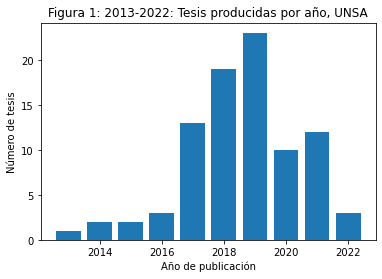

In [62]:
plt.bar(produccion_anual.index, list(produccion_anual["anios"]))
plt.xlabel('Año de publicación')
plt.ylabel('Número de tesis')
plt.title('Figura 1: 2013-2022: Tesis producidas por año, UNSA')

# 2.2. Tesis por grado
Ahora, analicemos cuántas tesis se produjeron por grado en UNSA en el periodo 2013-2022. Debido a que se almacenó un campo que contiene el grado obtenido en su forma conjugada gramatical, se procedió a estandarizar dichos grados a fin de que no se contabilice el mismo grado de forma separada. Un ejemplo de lo mencionado es que aparecen las palabras *"Ingeniero de Sistemas"* e *"Ingeniera de Sistemas"*.

In [50]:
ing_sist_variacion = ["Ingeniero de Sistemas", "Ingeniera de Sistemas", "Ingenieros de Sistemas", "Ingenieras de Sistemas"]
lic_ccomp_variacion = ["Licenciado en Ciencia de la Computación", "Licenciada en Ciencia de la Computación"]
dr_ccomp_variacion = ["Doctor en Ciencias de la Computación", "Doctora en Ciencias de la Computación"]

data.loc[data['grados'].isin(ing_sist_variacion), 'grados'] = 'Ingeniería de Sistemas'
data.loc[data['grados'].isin(lic_ccomp_variacion), 'grados'] = 'Ciencias de la Computación'
data.loc[data['grados'].isin(dr_ccomp_variacion), 'grados'] = 'Doctorado en Ciencias de la Computación'

Una vez estandarizado los grados, se elaborará un tabla con la frecuencias relativas porcentuales de las tesis por grado.

In [51]:
produccion_grado = data['grados'].value_counts(normalize=True).to_frame()
produccion_grado["grados"] = produccion_grado["grados"] * 100
produccion_grado

,grados
Ingeniería de Sistemas,69.318182
Doctorado en Ciencias de la Computación,17.045455
Ciencias de la Computación,12.500000
Maestro en Ciencias: Informática con mención en tecnologías de la información y comunicación en Gestión y Educación,1.136364


Visualicemos la tabla anterior mediante un gráfico circular.

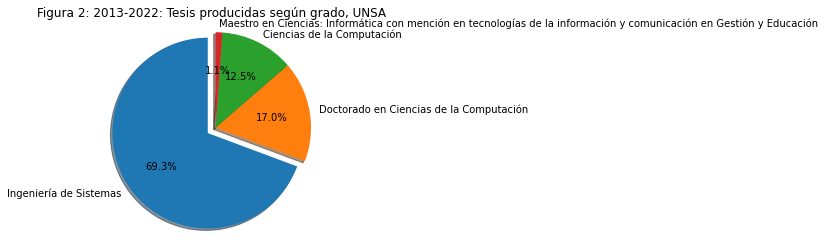

In [64]:
grados_plt = produccion_grado.index
# Declarar el tamaño de cada 'rebanada' y en sumatoria todos deben dar al 100%
sizes = list(produccion_grado["grados"])
# En este punto señalamos qué posición debe 'resaltarse' y el valor, si se coloca 0, se omite
explode = (0.1, 0, 0, 0)  
# Generar el marco de subploteos
fig1, ax1 = plt.subplots()
# Crear el gráfico, añadiendo los valores
ax1.pie(sizes, explode=explode, labels=grados_plt, autopct='%1.1f%%', shadow=True, startangle=90)
#señalamos la forma, en este caso 'equal' es para dar forma circular
ax1.axis('equal')
plt.title("Figura 2: 2013-2022: Tesis producidas según grado, UNSA")
# plt.legend()
plt.savefig('grafica_pastel.png')
plt.show()

# 3. Conclusiones
1. Basado en la figura 1, se podría afirmar que posiblemente la pandemia por COVID-19 tuvo un impacto en la producción de tesis en el periodo 2020-2022, ya que se observa un descenso notable.
2. Teniendo en cuenta la figura 2, se observa que la carrera de Ingeniería de Sistemas tiene la mayor de producción (69.3%) entre las carreras de interés.

# 4. ANEXOS

**Tabla 1**  
*Programas pertenecientes a la categoría Estadística a nivel de profesional (pregrado)*
| CÓDIGO |                      PROGRAMA                     |
|:------:|:-------------------------------------------------|
| 542016 |                    Estadística                    |
| 542026 |             Estadística e informática             |
| 542036 |              Estadística informática              |
| 542046 | Estadística para la gestión de servicios de salud |
| 542056 |               Ingeniería estadística              |
| 542066 |        Ingeniería estadística e informática       |
| 542076 |         Ingeniería estadística informática        |
| 542996 |           Otros programas en estadística          |

*Nota: Adaptado del "Clasificador Nacional de Programas e Instituciones de 
Educación Superior Universitaria, Pedagógica, Tecnológica y Técnico Productiva, 2018" por INEI.*

**Tabla 2**  
*Programas pertenecientes a la categoría Informática a nivel de profesional (pregrado)*
| CÓDIGO |                      PROGRAMA                     |
|:------:|:-------------------------------------------------|
| 611016 | Ciencias de la computación                  |
| 611016 | Ciencia de la computación                   |
| 611016 | Computación                                 |
| 611026 | Computación científica                      |
| 611036 | Computación e informática                   |
| 611046 | Computación y matemática                    |
| 611056 | Computación y sistemas                      |
| 611066 | Ingeniería de computación y sistemas        |
| 611076 | Ingeniería en computación e informática     |
| 611996 | Otros programas en ciencias de computación  |
| 612016 | Administración de redes y seguridad informática  |
| 612026 | Ciencias de la información                       |
| 612036 | Informática                                      |
| 612046 | Ingeniería de informática y estadística          |
| 612046 | Ingeniería informática y estadística             |
| 612056 | Ingeniería de la información                     |
| 612066 | Ingeniería de seguridad y auditoría informática  |
| 612076 | Ingeniería de sistemas                           |
| 612086 | Ingeniería de sistemas computacionales           |
| 612086 | Sistemas computacionales                         |
| 612096 | Ingeniería de sistemas con especialidad en ingeniería de software                               |
| 612096 | Ingeniería de sistemas computacionales con mención en ingeniería de software                    |
| 612106 | Ingeniería de sistemas con especialidad en sistemas de información                              |
| 612116 | Ingeniería de sistemas con mención en negocios y tecnologías de la información                  |
| 612116 | Ingeniería de sistemas computacionales con mención en negocios y tecnologías de la información  |
| 612126 | Ingeniería de sistemas con mención en redes y seguridad informática                             |
| 612126 | Ingeniería de sistemas computacionales con mención en redes y seguridad informática             |
| 612136 | Ingeniería de sistemas de información                                                           |
| 612146 | Ingeniería de sistemas de información y gestión                                                 |
| 612156 | Ingeniería de sistemas e informática                                                            |
| 612166 | Ingeniería de sistemas empresariales                               |
| 612176 | Ingeniería de sistemas y computación                               |
| 612176 | Ingeniería de sistemas y cómputo                                   |
| 612186 | Ingeniería de sistemas y gestión de tecnologías de la información  |
| 612186 | Ingeniería de sistemas y gestión de tecnologías de información     |
| 612196 | Ingeniería de sistemas y seguridad informática                     |
| 612206 | Ingeniería de sistemas y tecnológicas                              |
| 612206 | Ingeniería de sistemas y tecnologías                               |
| 612216 | Ingeniería de sistemas y telecomunicaciones                        |
| 612226 | Ingeniería de sistemas y telemática                                |
| 612236 | Ingeniería de software                                      |
| 612246 | Ingeniería de software y seguridad informática              |
| 612256 | Ingeniería de tecnologías de la información y sistemas      |
| 612266 | Ingeniería en tecnologías de la información y comunicación  |
| 612276 | Ingeniería en tecnologías y sistemas de información         |
| 612276 | Ingeniería de sistemas y tecnologías de la información      |
| 612286 | Ingeniería informática                                      |
| 612296 | Ingeniería informática y de sistemas                        |
| 612296 | Ingeniería en informática y sistemas                        |
| 612296 | Ingeniería informática - computer sciencie                  |
| 612296 | Ingeniería informática y de sistemas           |
| 612296 | Ingeniería informática y sistemas              |
| 612306 | Reparación de computadoras y redes             |
| 612996 | Otros programas en sistemas y cómputo          |
| 613016 | Ingeniería de la información y comunicaciones  |
| 613026 | Ingeniería de las telecomunicaciones           |
| 613036 | Ingeniería de las telecomunicaciones y redes   |
| 613036 | Ingeniería de telecomunicaciones y redes       |
| 613036 | Ingeniería en telecomunicaciones y redes       |
| 613046 | Ingeniería de redes y comunicaciones           |
| 613056 | Ingeniería de tecnologías de información y comunicación  |
| 613066 | Ingeniería de tecnologías de información y sistemas      |
| 613076 | Ingeniería de telecomunicaciones                         |
| 613086 | Ingeniería de telecomunicaciones y telemática            |
| 613086 | Ingeniería en telecomunicaciones y telemática            |
| 613096 | Ingeniería en telecomunicaciones                         |
| 613106 | Ingeniería en teleinformática                            |
| 613106 | Ingeniería teleinformática                               |
| 613116 | Técnica en ingeniería de telemática                      |
| 613996 | Otros programas en telecomunicaciones                    |

*Nota: Adaptado del "Clasificador Nacional de Programas e Instituciones de 
Educación Superior Universitaria, Pedagógica, Tecnológica y Técnico Productiva, 2018" por INEI.*